In [2]:
%reload_ext autoreload
%autoreload 2

import json
import pickle
import pandas as pd
import numpy as np
from scipy import stats
from lib import utils
from sklearn import metrics
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'times new roman'
plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = True

In [2]:
df = pd.read_csv('valid_sequence_data.csv',index_col=0)
df['total_money_heuristic'] = df['value_surplus'] == 60


df_meta = pd.read_excel('all_components_data.xlsx',sheet_name='meta_data')

df_meta['sex_value'] = df_meta['sex'] == 'Male'

df_demo = pd.merge(df,df_meta,on='worker_id').groupby('worker_id')[['sex_value','age']].mean().reset_index()

print('all answers are total money:', (df.groupby('worker_id')['total_money_heuristic'].sum() >= 12).sum())

df_demo.mean()


all answers are total money: 62


worker_id    435026.633540
sex_value         0.552795
age              40.720497
dtype: float64

In [13]:
df[(df['value_surplus'] <= 60) & (df['value_surplus'] >= 0)].shape[0] / 2254

0.8637976929902396

In [12]:
df[(df['value_surplus'] > 60)].shape[0] / 2254

0.12821650399290152

In [52]:
# Spearman rank-order correlation
# the entire sample
print(stats.spearmanr(df['value_surplus'],df['front_amount']))

# cluster 1
print(stats.spearmanr(df[df['label_kmeans'] == 0]['value_surplus'],
                df[df['label_kmeans'] == 0]['front_amount']))

# cluster 2
print(stats.spearmanr(df[df['label_kmeans'] == 1]['value_surplus'],
                    df[df['label_kmeans'] == 1]['front_amount']))

SignificanceResult(statistic=-0.04871921859566945, pvalue=0.020717183445793052)
SignificanceResult(statistic=-0.01543062586818839, pvalue=0.5563145093935986)
SignificanceResult(statistic=-0.1892458603593054, pvalue=7.190225038954018e-08)


In [53]:
# Kendall’s tau
# the entire sample
print(stats.kendalltau(df['value_surplus'],df['front_amount']))

# cluster 1
print(stats.kendalltau(df[df['label_kmeans'] == 0]['value_surplus'],
                df[df['label_kmeans'] == 0]['front_amount']))

# cluster 2
print(stats.kendalltau(df[df['label_kmeans'] == 1]['value_surplus'],
                    df[df['label_kmeans'] == 1]['front_amount']))

SignificanceResult(statistic=-0.038273860587928185, pvalue=0.01839663835549035)
SignificanceResult(statistic=-0.012553623458832002, pvalue=0.5520872925395864)
SignificanceResult(statistic=-0.1476984023409496, pvalue=2.5585460680410593e-08)


In [40]:
stats.mannwhitneyu(df['value_surplus'][df['label_kmeans'] == 0],df['value_surplus'][df['label_kmeans'] == 1])

MannwhitneyuResult(statistic=1059304.0, pvalue=2.668221610224322e-251)

In [6]:
stats.mannwhitneyu(df['value_surplus'][df['choice_peli'] == 1],df['value_surplus'][df['choice_peli'] == 0])

MannwhitneyuResult(statistic=421520.0, pvalue=0.0035907175383260576)

In [19]:
stats.chi2_contingency(pd.crosstab(df['choice_peli'], df['label_gmm']))

Chi2ContingencyResult(statistic=11.063173450343989, pvalue=0.0008805929528317736, dof=1, expected_freq=array([[ 327.13043478,  204.86956522],
       [1058.86956522,  663.13043478]]))

In [18]:
df['label_gmm'].sum() / 14

62.0

In [44]:
df[(df['label_kmeans'] == 1) & (df['value_surplus'] > 0) & (df['value_surplus'] < 60)].shape[0] / df[(df['label_kmeans'] == 1)].shape[0]

0.7907268170426065

In [28]:
(df.groupby('worker_id').sum()['total_money_heuristic'] == 0).sum()

65

In [2]:
with open('bootstrap_rlm_fe_label_k.pkl', 'rb') as file:
    bootstrap_rlm_fe_label_k = pickle.load(file)

print(bootstrap_rlm_fe_label_k.conf_int())
print('M-W Criterion:',bootstrap_rlm_fe_label_k.muller_welsh_criterion())

                    median_coef        se       mad   ci_lower   ci_upper
const                 52.829221  0.620943  0.372760  51.695819  54.202981
front_amount_6m_0     -0.000643  0.000620  0.000412  -0.001906   0.000509
front_amount_12m_0    -0.000910  0.000625  0.000445  -0.002124   0.000279
front_amount_6m_1     -0.017604  0.002419  0.001636  -0.022255  -0.012798
front_amount_12m_1    -0.021964  0.002327  0.001627  -0.026525  -0.017581
choice_peli            1.553705  0.673897  0.414639   0.112228   2.730432
M-W Criterion: 139.58908884625788


In [36]:
with open('bootstrap_rlm_fe_label.pkl', 'rb') as file:
    bootstrap_rlm_fe_label_gm = pickle.load(file)

print(bootstrap_rlm_fe_label_gm.conf_int())
print('M-W Criterion:',bootstrap_rlm_fe_label_gm.muller_welsh_criterion())

                    median_coef        se       mad   ci_lower   ci_upper
const                 52.306397  0.650041  0.400422  51.110218  53.740399
front_amount_6m_0     -0.009475  0.001339  0.000902  -0.012143  -0.006931
front_amount_12m_0    -0.012100  0.001410  0.000989  -0.014877  -0.009443
front_amount_6m_1      0.000472  0.000639  0.000409  -0.000802   0.001817
front_amount_12m_1     0.000723  0.000577  0.000364  -0.000347   0.001853
choice_peli            1.793923  0.686338  0.431331   0.309061   3.057770
M-W Criterion: 143.60660441079636


In [3]:
with open('bootstrap_rlm_fe_baseline_k.pkl', 'rb') as file:
    bootstrap_rlm_fe_baseline_k = pickle.load(file)

print(bootstrap_rlm_fe_baseline_k.conf_int())
print('M-W Criterion:',bootstrap_rlm_fe_baseline_k.muller_welsh_criterion())

                  median_coef        se       mad   ci_lower   ci_upper
const               52.272494  0.592342  0.348155  51.150431  53.641380
front_amount_6m     -0.004649  0.000812  0.000562  -0.006226  -0.003015
front_amount_12m    -0.006037  0.000840  0.000563  -0.007710  -0.004389
choice_peli          1.550211  0.647237  0.382408   0.133744   2.850291
M-W Criterion: 146.73420227957365


In [34]:
with open('bootstrap_rlm_fe_baseline.pkl', 'rb') as file:
    bootstrap_rlm_fe_baseline_gm = pickle.load(file)

print(bootstrap_rlm_fe_baseline_gm.conf_int())
print('M-W Criterion:',bootstrap_rlm_fe_baseline_gm.muller_welsh_criterion())

                  median_coef        se       mad   ci_lower   ci_upper
const               52.290474  0.634875  0.388110  51.093774  53.587144
front_amount_6m     -0.004604  0.000810  0.000524  -0.006107  -0.002984
front_amount_12m    -0.006058  0.000864  0.000571  -0.007698  -0.004339
choice_peli          1.496759  0.686113  0.436900   0.188556   2.906631
M-W Criterion: 146.73790980392337


In [44]:
with open('bootstrap_rlm_pool_label_k.pkl', 'rb') as file:
    bootstrap_rlm_pool_label_k = pickle.load(file)

print(bootstrap_rlm_pool_label_k.conf_int())
print('M-W Criterion:',bootstrap_rlm_pool_label_k.muller_welsh_criterion())

                    median_coef        se       mad   ci_lower   ci_upper
const                 58.381029  0.629061  0.436021  57.114893  59.563410
front_amount_6m_0      0.009427  0.001359  0.000900   0.006846   0.012147
front_amount_12m_0     0.008684  0.001513  0.001059   0.005801   0.011650
front_amount_6m_1     -0.064912  0.003550  0.002388  -0.071966  -0.058042
front_amount_12m_1    -0.069267  0.003303  0.002210  -0.075744  -0.063339
choice_peli           -2.254707  0.552220  0.369562  -3.353969  -1.160216
M-W Criterion: 250.58568371091397


In [33]:
with open('bootstrap_rlm_pool_label.pkl', 'rb') as file:
    bootstrap_rlm_pool_label_gm = pickle.load(file)

print(bootstrap_rlm_pool_label_gm.conf_int())
print('M-W Criterion:',bootstrap_rlm_pool_label_gm.muller_welsh_criterion())

                    median_coef        se       mad   ci_lower   ci_upper
const                 56.837910  0.784683  0.533065  55.231471  58.279624
front_amount_6m_0     -0.025582  0.002735  0.001893  -0.030967  -0.020104
front_amount_12m_0    -0.029517  0.002938  0.001990  -0.034966  -0.023267
front_amount_6m_1      0.012948  0.001621  0.001125   0.010052   0.016296
front_amount_12m_1     0.013050  0.001594  0.001109   0.009846   0.016232
choice_peli           -0.556588  0.741638  0.490530  -2.036535   0.789587
M-W Criterion: 382.35402150373045


In [46]:
with open('bootstrap_rlm_pool_baseline_k.pkl', 'rb') as file:
    bootstrap_rlm_pool_baseline_k = pickle.load(file)

print(bootstrap_rlm_pool_baseline_k.conf_int())
print('M-W Criterion:',bootstrap_rlm_pool_baseline_k.muller_welsh_criterion())

                  median_coef        se       mad   ci_lower   ci_upper
const               57.265395  0.888236  0.599257  55.493310  58.896586
front_amount_6m     -0.003025  0.002053  0.001413  -0.007158   0.001075
front_amount_12m    -0.004436  0.002161  0.001471  -0.008703  -0.000201
choice_peli         -2.445123  0.814077  0.518281  -4.045346  -0.828407
M-W Criterion: 456.53468793091855


In [32]:
with open('bootstrap_rlm_pool_baseline.pkl', 'rb') as file:
    bootstrap_rlm_pool_baseline_gm = pickle.load(file)

print(bootstrap_rlm_pool_baseline_gm.conf_int())
print('M-W Criterion:',bootstrap_rlm_pool_baseline_gm.muller_welsh_criterion())

                  median_coef        se       mad   ci_lower   ci_upper
const               57.236325  0.856312  0.586479  55.535867  58.852683
front_amount_6m     -0.003022  0.002016  0.001395  -0.006727   0.000850
front_amount_12m    -0.004415  0.002089  0.001448  -0.008606  -0.000662
choice_peli         -2.506136  0.790877  0.532557  -4.067814  -0.978330
M-W Criterion: 456.5015899252077


In [19]:
# Make regression tables
# load the regression results
with open('model_reg_result_k.json', 'r') as f:
    reg_result = json.load(f)

# some OLS results contain the 'Intercept' term
# replace it by 'const' 
for m in list(reg_result.keys()):
    if 'Intercept' in reg_result[m]['coef_name']:
        index_to_replace = reg_result[m]['coef_name'].index('Intercept')
        reg_result[m]['coef_name'][index_to_replace] = 'const'

# column names for the dataframe
indicators = ['nobs','rsquared_adj']
col_name_list = ['b_front_amount_6m','se_front_amount_6m',
                'b_front_amount_12m','se_front_amount_12m',
                'b_front_amount_6m_0','se_front_amount_6m_0',
                'b_front_amount_12m_0','se_front_amount_12m_0',
                'b_front_amount_6m_1','se_front_amount_6m_1',
                'b_front_amount_12m_1','se_front_amount_12m_1',
                'b_choice_peli','se_choice_peli',
                'b_const','se_const'] 

col_names = col_name_list + indicators

# make a dataframe in which columns are specified using the column names
# each row of this dataframe is correspondent to a model 
result_table = utils.draw_df_from_result(reg_result,col_names)

# specific the indices used for table
param_list = [r'$Y_1\cdot1\{T=T_L\}$',
            '',
            r'$Y_1\cdot1\{T=T_H\}$',
            '',
            r'$Y_1\cdot1\{T=T_L\}\times$CL1',
            '',
            r'$Y_1\cdot1\{T=T_H\}\times$CL1',
            '',
            r'$Y_1\cdot1\{T=T_L\}\times$CL2',
            '',
            r'$Y_1\cdot1\{T=T_H\}\times$CL2',
            '',
            'PELI',
            '',
            'Constant',
            '',
            'observations']

# make a grand table
reg_table = pd.DataFrame(result_table.iloc[:,:-1].values.T,columns=result_table['model'])
reg_table.iloc[-1,4:] = np.repeat('',4)
reg_table.index.name = None
reg_table.columns.name = None


In [49]:
reg_table_combined = reg_table.iloc[:,[0,1,2,3,6,7]]
reg_table_combined.columns = ['(1) Pool', '(2) Pool', '(3) FE', '(4) FE','(5) RLM', '(6) RLM']
reg_table_combined.loc['muller_welsh'] = [
                    '','','','',
                    str(round(bootstrap_rlm_fe_baseline_k.muller_welsh_criterion(),3)),
                    str(round(bootstrap_rlm_fe_label_k.muller_welsh_criterion(),3))]
reg_table_combined.index = param_list + ['adj-$R^2$','Muller-Welsh']

utils.make_table(reg_table_combined,'tables/reg_combined.tex')

C:\Users\zarkwang\AppData\Local\Temp\ipykernel_7200\3144719332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_table_combined.loc['muller_welsh'] = [


In [50]:

# split the OLS table from the grand table
reg_table_1 = reg_table.iloc[:,:4]
reg_table_1.columns = ['(1) Pooled', '(2) Pooled', '(3) FE', '(4) FE']
reg_table_1.index = param_list + ['adj-$R^2$']

# split the RLM table from the grand table
reg_table_2 = reg_table.iloc[:-1,4:]
reg_table_2.loc['muller_welsh'] = np.round([
                    bootstrap_rlm_pool_baseline_k.muller_welsh_criterion(),
                    bootstrap_rlm_pool_label_k.muller_welsh_criterion(),
                    bootstrap_rlm_fe_baseline_k.muller_welsh_criterion(),
                    bootstrap_rlm_fe_label_k.muller_welsh_criterion()],3).astype(str)

reg_table_2.columns = ['(5) Pooled', '(6) Pooled', '(7) FE', '(8) FE']
reg_table_2.index = param_list + ['Muller-Welsh']

# write latex code
utils.make_table(reg_table_1,'tables/reg_ols.tex')
utils.make_table(reg_table_2,'tables/reg_rlm.tex')

In [36]:
# Make table for GMM results
with open('model_reg_result_gm.json', 'r') as f:
    reg_result = json.load(f)

col_names = col_name_list[4:] + ['nobs']

result_table = utils.draw_df_from_result(reg_result,col_names)

reg_table = pd.DataFrame(result_table.iloc[[1,3],:-1].values.T,columns=result_table['model'][[1,3]])
reg_table.columns.name = None
reg_table.loc['muller_welsh'] = np.round([
                    bootstrap_rlm_pool_label_gm.muller_welsh_criterion(),
                    bootstrap_rlm_fe_label_gm.muller_welsh_criterion()],3).astype(str)

reg_table.columns = ['(1) Pooled', '(2) FE']
reg_table.index = param_list[4:] + ['Muller-Welsh']

utils.make_table(reg_table,'tables/reg_rlm_GMM.tex')

In [3]:
with open('bootstrap/bootstrap_rlm_GMM_fe_label.pkl', 'rb') as file:
    bootstrap_rlm_fe_label_full_gm = pickle.load(file)

print(bootstrap_rlm_fe_label_full_gm.conf_int())
print('M-W Criterion:',bootstrap_rlm_fe_label_full_gm.muller_welsh_criterion())

                    median_coef        se       mad   ci_lower   ci_upper
const                 52.241917  0.357480  0.246990  51.584584  52.991907
front_amount_6m_0     -0.009450  0.000971  0.000648  -0.011334  -0.007524
front_amount_12m_0    -0.012113  0.000969  0.000677  -0.013936  -0.010143
front_amount_6m_1      0.000456  0.000446  0.000289  -0.000417   0.001356
front_amount_12m_1     0.000652  0.000406  0.000276  -0.000128   0.001472
choice_peli            1.878645  0.389942  0.273772   1.120825   2.593016
M-W Criterion: 142.30425182614027


In [8]:
with open('bootstrap/full_bootstrap_rlm_fe_label_k.pkl', 'rb') as file:
    bootstrap_rlm_fe_label_full = pickle.load(file)

print(bootstrap_rlm_fe_label_full.conf_int())
print('M-W Criterion:',bootstrap_rlm_fe_label_full.muller_welsh_criterion())

                    median_coef        se       mad   ci_lower   ci_upper
const                 52.721028  0.368049  0.246641  52.032330  53.471182
front_amount_6m_0     -0.000727  0.000446  0.000302  -0.001535   0.000151
front_amount_12m_0    -0.000947  0.000456  0.000304  -0.001889  -0.000074
front_amount_6m_1     -0.017358  0.001583  0.001019  -0.020339  -0.014093
front_amount_12m_1    -0.021893  0.001560  0.001081  -0.024835  -0.018782
choice_peli            1.622464  0.388625  0.266264   0.828622   2.318951
M-W Criterion: 138.35394656438257


In [9]:
with open('bootstrap/full_bootstrap_rlm_fe_baseline_k.pkl', 'rb') as file:
    bootstrap_rlm_fe_baseline_full = pickle.load(file)

print(bootstrap_rlm_fe_baseline_full.conf_int())
print('M-W Criterion:',bootstrap_rlm_fe_baseline_full.muller_welsh_criterion())

                  median_coef        se       mad   ci_lower   ci_upper
const               52.280060  0.370942  0.258848  51.608717  52.990787
front_amount_6m     -0.004677  0.000542  0.000358  -0.005700  -0.003596
front_amount_12m    -0.006076  0.000563  0.000378  -0.007272  -0.005033
choice_peli          1.540714  0.400306  0.273646   0.764057   2.347958
M-W Criterion: 145.42191181173675


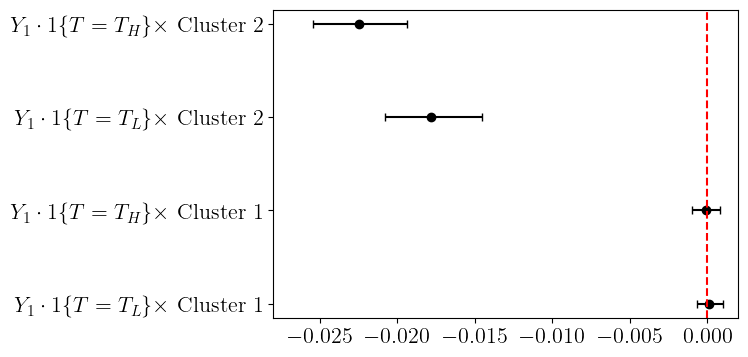

In [26]:
ci_table = bootstrap_rlm_fe_label_full.conf_int().iloc[1:,:]
ci_table['coef'] = bootstrap_rlm_fe_label_full.model.params[bootstrap_rlm_fe_label_full.param_names]
ci_table = ci_table.iloc[:-1,:]

plt.figure(figsize=(6, 4)) 
plt.errorbar(x=ci_table['coef'], y=ci_table.index, 
             xerr=[ci_table['median_coef'] - ci_table['ci_lower'], ci_table['ci_upper'] - ci_table['median_coef']], 
             fmt='none', color='black',
             capsize=3)
plt.scatter(x=ci_table['coef'], y=ci_table.index, color = 'black')
plt.axvline(x = 0, color = 'red', linestyle = 'dashed')


label_param_list = [
            r'$Y_1\cdot1\{T=T_L\}\times$ Cluster 1',
            r'$Y_1\cdot1\{T=T_H\}\times$ Cluster 1',
            r'$Y_1\cdot1\{T=T_L\}\times$ Cluster 2',
            r'$Y_1\cdot1\{T=T_H\}\times$ Cluster 2'
            ]

plt.yticks(ci_table.index,label_param_list)
plt.xticks(np.arange(-0.025,0.005,step=0.005))
plt.xlim((-0.028,0.002))
plt.show()

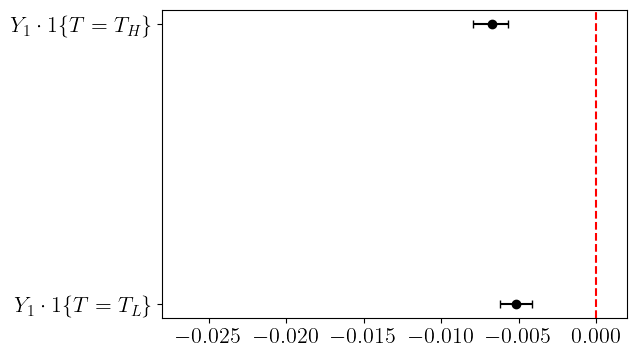

In [24]:
ci_table = bootstrap_rlm_fe_baseline_full.conf_int().iloc[1:,:]
ci_table['coef'] = bootstrap_rlm_fe_baseline_full.model.params[bootstrap_rlm_fe_baseline_full.param_names]
ci_table = ci_table.iloc[:-1,:]

plt.figure(figsize=(6, 4)) 
plt.errorbar(x=ci_table['coef'], y=ci_table.index, 
             xerr=[ci_table['median_coef'] - ci_table['ci_lower'], ci_table['ci_upper'] - ci_table['median_coef']], 
             fmt='none', color='black',
             capsize=3)
plt.scatter(x=ci_table['coef'], y=ci_table.index, color = 'black')
plt.axvline(x = 0, color = 'red', linestyle = 'dashed')

label_param_list = [
            r'$Y_1\cdot1\{T=T_L\}$',
            r'$Y_1\cdot1\{T=T_H\}$'
            ]

plt.yticks(ci_table.index,label_param_list)
plt.xticks(np.arange(-0.025,0.005,step=0.005))
plt.xlim((-0.028,0.002))
plt.show()

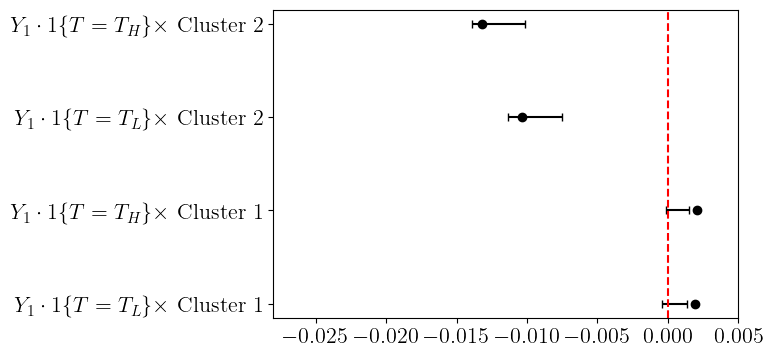

In [4]:
ci_table = bootstrap_rlm_fe_label_full_gm.conf_int()
ci_table['coef'] = bootstrap_rlm_fe_label_full_gm.model.params[bootstrap_rlm_fe_label_full_gm.param_names]
ci_table = ci_table.iloc[1:-1,:]
ci_table = ci_table.loc[['front_amount_6m_1', 'front_amount_12m_1', 'front_amount_6m_0','front_amount_12m_0']]

plt.figure(figsize=(6, 4)) 
plt.errorbar(x=ci_table['median_coef'], y=ci_table.index, 
             xerr=[ci_table['median_coef'] - ci_table['ci_lower'], ci_table['ci_upper'] - ci_table['median_coef']], 
             fmt='none', color='black',
             capsize=3)
plt.scatter(x=ci_table['coef'], y=ci_table.index, color = 'black')
plt.axvline(x = 0, color = 'red', linestyle = 'dashed')


label_param_list = [
            r'$Y_1\cdot1\{T=T_L\}\times$ Cluster 1',
            r'$Y_1\cdot1\{T=T_H\}\times$ Cluster 1',
            r'$Y_1\cdot1\{T=T_L\}\times$ Cluster 2',
            r'$Y_1\cdot1\{T=T_H\}\times$ Cluster 2'
            ]

plt.yticks(ci_table.index,label_param_list)
plt.xticks(np.arange(-0.025,0.01,step=0.005))
plt.xlim((-0.028,0.005))
plt.show()